### This notebool is to analysis the ccae rul on PEWC data ### (可作為NTU RUL 預測試)

In [1]:
# import used functioons 
#  import tools 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed


Create ccae model

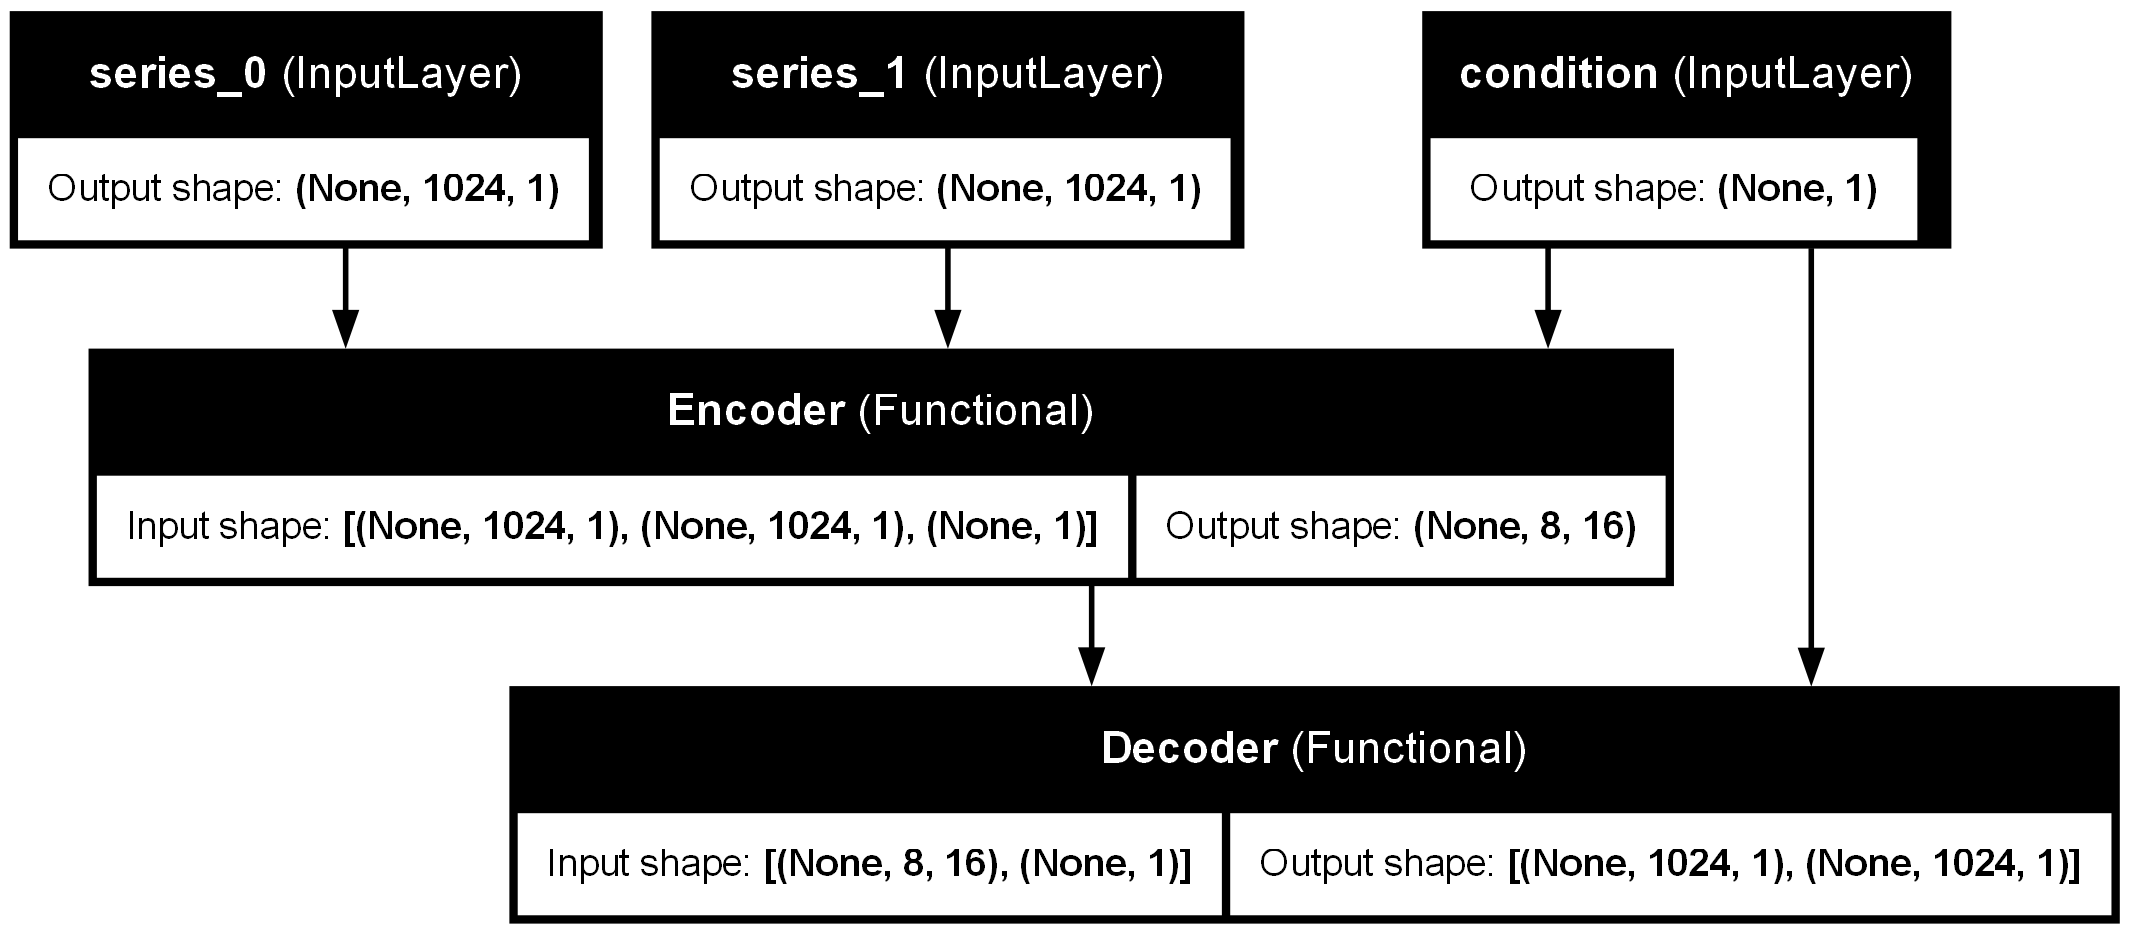

In [2]:
# 自動重新加載模塊
%reload_ext autoreload
%autoreload 2


from rul_features.rul_data_read import read_rul_data
from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train


# 模型存儲相關資料
model_saved_path='PEWC_models'


model_type = 'I2_in_I2_out'
# model_type = 'V2_in_I2_out'
# model_type = 'V2I2_in_V2I2_out'

model_save_name=os.path.join(model_saved_path, f"{model_type}.keras")


if model_type == 'I2_in_I2_out':
    my_ccae_model1,_,__cached__ = CCAE_model_build_train.build_CCAE_model([1,1], sequence_length=1024, condition_dim=1, 
                                                                          model_name = model_save_name, file_name=f'{model_type}.png')
if model_type == 'V2_in_I2_out':
    my_ccae_model1,_,__cached__ = CCAE_model_build_train.build_CCAE_model([1,1], sequence_length=1024, condition_dim=1, 
                                                                          model_name = model_save_name,file_name=f'{model_type}.png')
if model_type == 'V2I2_in_V2I2_out':
    my_ccae_model1,_,__cached__ = CCAE_model_build_train.build_CCAE_model([1,1,1,1], sequence_length=1024, condition_dim=1, 
                                                                          model_name = model_save_name,file_name=f'{model_type}.png')

# 顯示模型結構
# my_ccae_model1.summary()
plot_model(my_ccae_model1, to_file= os.path.join(model_saved_path,'V2I2_in_V2I2_out_model.png'), show_shapes=True, show_layer_names=True)



Train the model and chack the training process

In [3]:
# 自動重新加載模塊
%reload_ext autoreload
%autoreload 2
# from test_algs.CCAE_ntu_rul import CCAE_model_build_train
# import time
# import matplotlib.pyplot as plt

rul2_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2"
rul5_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5"

# 取出 rul2_dataset_path 中的所有 file 名稱
rul2_files = [f for f in os.listdir(rul2_dataset_path) if os.path.isfile(os.path.join(rul2_dataset_path, f))]
rul2_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

# 取前 N 個資料作為訓練集
N=100
train_set_files= rul2_files[:N]
test_set_files= rul2_files[N:]
train_set=[]
test_set=[]

# 取出測試資料rul2_data
for file in train_set_files:
    file_path = os.path.join(rul2_dataset_path, file)

    # 讀取 rul2_data
    rul2_data = read_rul_data(file_path)
    voltage_alpha = np.array(rul2_data["Voltage alpha"])
    voltage_beta = np.array(rul2_data["Voltage beta"])
    current_alpha = np.array(rul2_data["Current alpha"])
    current_beta = np.array(rul2_data["Current beta"])
    
    # std normalization
    current_alpha_normalized = (current_alpha - np.mean(current_alpha)) / np.std(current_alpha)
    current_beta_normalized = (current_beta - np.mean(current_beta)) / np.std(current_beta)
    voltage_alpha_normalized = (voltage_alpha - np.mean(voltage_alpha)) / np.std(voltage_alpha)
    voltage_beta_normalized = (voltage_beta - np.mean(voltage_beta)) / np.std(voltage_beta)
    
    # 根據 model_type 組合訓練資料
    if model_type == 'I2_in_I2_out':
        train_set.append(np.concatenate((current_alpha_normalized, current_beta_normalized), axis=1))
    if model_type == 'V2_in_I2_out':
        train_set.append(np.concatenate((voltage_alpha_normalized, voltage_beta_normalized, current_alpha_normalized, current_beta_normalized), axis=1))
    if model_type == 'V2I2_in_V2I2_out':
        train_set.append(np.concatenate((voltage_alpha_normalized, voltage_beta_normalized, current_alpha_normalized, current_beta_normalized), axis=1))
    
# 合併測試資料 shape=(N,1024,2)
train_input_raw=np.stack(train_set, axis=0)

# 進行資料增強 shape=(N*[(L-W)/1024+1],1024,2)
from test_algs.CCAE_ntu_rul import data_augmentation
train_input_augmented = []
for i in range(train_input_raw.shape[0]):
    train_input_augmented.append(data_augmentation(train_input_raw[i], time_steps=1024, window_size=10, cols=[0], random_seed=42))
# 將資料切片合成近一個batch  
train_input_augmented =  np.concatenate(train_input_augmented) 
print(f"train_input_augmented shape: {train_input_augmented.shape}")



train_input_augmented shape: (9800, 1024, 2)


In [ ]:

# --------------------模型訓練---------------------
time_start = time.time()
Labels = np.full(train_input_augmented.shape[0], 1)
epochs=20
batch_size=100
my_ccae_model1_trained, train_history=CCAE_model_build_train.CCAE_train(my_ccae_model1,model_type,model_save_name, 
                                                                        train_input_augmented, label=1, 
                                                                        epochs=epochs, batch_size=batch_size)
print("Training time:", time.time() - time_start)

# 繪製 Loss
plt.figure()
plt.plot(train_history.history['loss'], label='Train Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


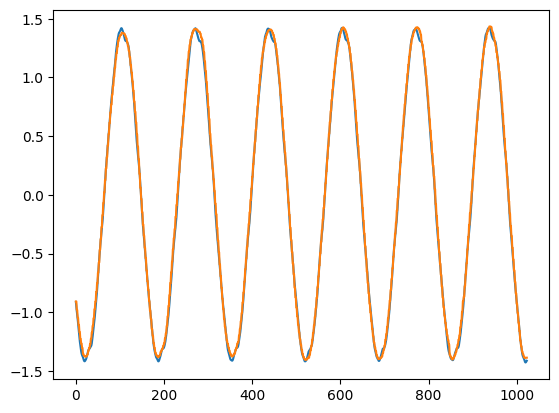

In [6]:
verify_results = my_ccae_model1_trained.predict([train_input_augmented[0:1,:,0:1], train_input_augmented[0:1,:,1:2] , np.array([[1]]) ])
# check the reconstruction result 
plt.figure()
plt.plot(train_input_augmented[0,:,0], label='Input Alpha')
plt.plot(np.squeeze(np.array(verify_results[0])), label='Reconstructed Alpha')


Time relation check 

In [ ]:
# 取前 N 個資料作為訓練集
N=100
train_set_files= rul2_files[:N]
test_set_files= rul2_files[N:]
train_set=[]
test_set=[]

# 取出測試資料rul2_data
for file in test_set_files:
    rul2_data = read_rul_data(os.path.join(rul2_dataset_path, file))
    # 保留前2000點 ，避免後續採樣數增加(4000點)之資料格式不一致
    current_alpha = np.array(rul2_data["Current alpha"])[:2000]
    current_beta = np.array(rul2_data["Current beta"])[:2000]
    # std normalization
    current_alpha_normalized = (current_alpha - np.mean(current_alpha)) / np.std(current_alpha)
    current_beta_normalized = (current_beta - np.mean(current_beta)) / np.std(current_beta)
    test_set.append(np.concatenate((current_alpha_normalized, current_beta_normalized), axis=1))
    
# 合併測試資料 shape=(N,1024,2)
test_input_raw=np.stack(test_set, axis=0)


# 進行資料增強 shape=(N*[(L-W)/1024+1],1024,2)
test_input_augmented = []
for i in range(test_input_raw.shape[0]):
    test_input_augmented.append(data_augmentation(test_input_raw[i], time_steps=1024, window_size=10, cols=[0], random_seed=42))
# 將資料切片合成近一個batch  
test_input_augmented =  np.concatenate(test_input_augmented) 

test_input_augmented.shape
# 套用模型




KeyboardInterrupt: 

: 

In [7]:
# 使用訓練好的模型進行預測
test_results = my_ccae_model1_trained.predict([test_input_augmented[:,:,0:1], 
                                               test_input_augmented[:,:,1:2],
                                               np.ones((test_input_augmented.shape[0], 1)) ])


17242/17242 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


Text(0, 0.5, 'Error')

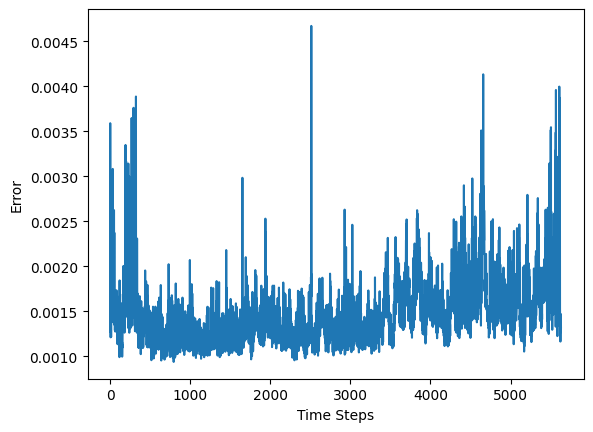

In [ ]:
# 計算重建殘差
# 以 one_test_batch_files 個檔案維一個資料集分析變化
files_per_test_batch=1
augmented_data_number_per_sample = int((2000 - 1024) / 10 + 1)
data_per_test_bartch=augmented_data_number_per_sample*files_per_test_batch

# 儲存重建誤差值
reconstruction_errs_batches = [] # 以batch 儲存重建誤差原始值
reconstruction_mse_batches=[]# 儲存重建誤差mse
for start_idx in range(0, test_input_augmented.shape[0], data_per_test_bartch):
    end_idx=start_idx + data_per_test_bartch
    reconstruc_err_per_batch=test_input_augmented[start_idx:end_idx,:,0:1] - (test_results[0][start_idx:end_idx,:])
    reconstruction_errs_batches.append(reconstruc_err_per_batch)
    # 將批次誤差一維化並聚攏，方便計算最終mse值
    flattened_batch_err= np.array(reconstruc_err_per_batch).flatten()
    reconstruction_mse_batches.append(np.mean(np.square(flattened_batch_err)))

# # 繪製重建殘差
plt.figure()
plt.plot( reconstruction_mse_batches, label='Reconstruction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error')

雙軸電流誤差計算

In [ ]:
# 計算重建殘差
# 以 one_test_batch_files 個檔案維一個資料集分析變化

# 儲存重建誤差值
reconstruction_errs_batches_ab = [] # 以batch 儲存重建誤差原始值(每一元素為該批次資料之原始重建誤差)
reconstruction_mse_batches_ab=[]# 儲存重建誤差mse(每一點為該批次資料之mse)
for start_idx in range(0, test_input_augmented.shape[0], data_per_test_bartch):
    end_idx=start_idx + data_per_test_bartch
    reconstruc_err_per_batch_alpha=test_input_augmented[start_idx:end_idx,:,0:1] - (test_results[0][start_idx:end_idx,:])
    reconstruc_err_per_batch_beta=test_input_augmented[start_idx:end_idx,:,1:2] - (test_results[1][start_idx:end_idx,:])
    reconstruc_err_per_batch = np.concatenate((reconstruc_err_per_batch_alpha, reconstruc_err_per_batch_beta), axis=1)
    reconstruction_errs_batches_ab.append(reconstruc_err_per_batch)
    
    # 將批次誤差一維化並聚攏，方便計算最終mse值
    flattened_batch_err= np.array(reconstruc_err_per_batch).flatten()
    reconstruction_mse_batches_ab.append(np.mean(np.square(flattened_batch_err)))

Text(0, 0.5, 'Error')

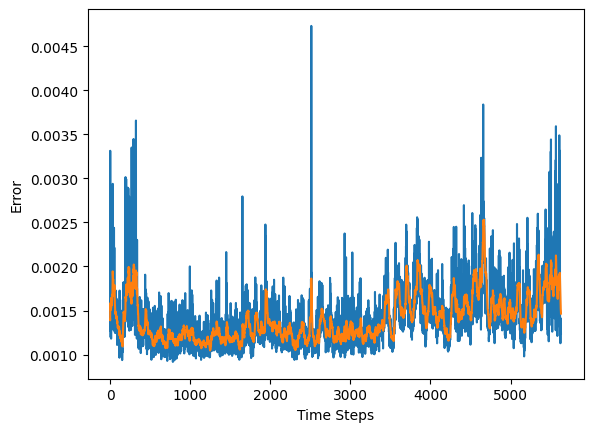

In [ ]:

# 對 reconstruction_mse_batches_ab 做指數平滑
def exponential_smoothing(data, alpha=0.1):
    smoothed = [data[0]]
    for v in data[1:]:
        smoothed.append(alpha * v + (1 - alpha) * smoothed[-1])
    return smoothed

reconstruction_mse_batches_ab_smooth = exponential_smoothing(reconstruction_mse_batches_ab, alpha=0.1)
# # 繪製重建殘差
plt.figure()

plt.plot( reconstruction_mse_batches_ab, label='Reconstruction Error')
plt.plot( reconstruction_mse_batches_ab_smooth, label='Reconstruction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error')

Save the prediction result

In [1]:
import pickle
from datetime import datetime

epochs=10
batch_size=100

model_type = 'I2_in_I2_out'

prediction_results = {
    "Model_type": model_type,
    "Model_name": model_save_name,
    "Input_type": "alpha_beta",
    "Output_type": "alpha_beta",
    "Training_info": {
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": "adam",
        "loss": "mse",
    },
    "Evaluation": {
        "reconstruction_errs_batches_alpha": reconstruction_errs_batches_ab,
        "reconstruction_mse_batches": reconstruction_mse_batches_ab,
    },
    "Timestamps": {
        "saved_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

result_save_path=os.path.join(model_saved_path, f"{model_type}_results.pkl")
with open(result_save_path, "wb") as f:
    pickle.dump(prediction_results, f)


NameError: name 'model_save_name' is not defined